In this tutorial you'll learn how to

* update groups and fields
* use heartbeats

For this notebook you need `astropy` and `matplotlib` in addition to the `simframe` requirements.

# Updating Groups and Fields

In this example we revisit the orbital integration from the previous tutorial. But this time we also want to calculate the equilibrium temperature on Earth. That is not a quantity that we need to integrate. We can simply calculate it from the other quantities. But we have to tell `simframe` how to do it.

**Setting up the problem**

The problem setup follows the previous example. Please have a look there for more details.

In [1]:
from simframe import Frame

In [2]:
sim = Frame(description="Earth-Sun system")

In [3]:
sim.addgroup("Sun")
sim.addgroup("Earth")

In [4]:
import astropy.constants as c
import astropy.units as u

In [5]:
AU   = (1.*u.au).si.value
day  = (1.*u.day).si.value
G    = c.G.si.value
year = (1.*u.year).si.value

M_earth = c.M_earth.si.value
M_sun   = c.M_sun.si.value

**Earth**

In [6]:
import numpy as np

In [7]:
sim.Earth.addfield("M", M_earth, description="Mass [kg]", constant=True)
sim.Earth.addfield("r", np.zeros(3), description="Position [m]")
sim.Earth.addfield("v", np.zeros(3), description="Velocity [m/s]")

**Sun**

In [8]:
sim.Sun.addfield("M", c.M_sun.si.value, description="Mass [kg]", constant=True)
sim.Sun.addfield("r", np.zeros(3), description="Position [m]")
sim.Sun.addfield("v", np.zeros(3), description="Velocity [m/s]")

**Integration variable**

In [9]:
sim.addintegrationvariable("t", 0., description="Time [s]")

In [10]:
dt = 1.*day

In [11]:
def f_dt(frame):
    return dt

In [12]:
sim.t.updater = f_dt

In [13]:
snapwidth = 5.*day
tmax = 2.*year

In [14]:
sim.t.snapshots = np.arange(snapwidth, tmax+1, snapwidth)

**Writer**

In [15]:
from simframe import writers

In [16]:
sim.writer = writers.namespacewriter

In [17]:
sim.writer.dumping = False
sim.writer.verbosity = 0

**Differential equations**

In [18]:
def dr_Earth(frame, x, Y):
    return frame.Earth.v

def dr_Sun(frame, x, Y):
    return frame.Sun.v

In [19]:
# Gravitational acceleration
def ag(M, r, R):
    direction = r-R
    distance = np.linalg.norm(direction)
    return -G * M * direction / distance**3

In [20]:
def dv_Earth(frame, x, Y):
    return ag(frame.Sun.M, frame.Earth.r, frame.Sun.r)

def dv_Sun(frame, x, Y):
    return ag(frame.Earth.M, frame.Sun.r, frame.Earth.r)

In [21]:
sim.Earth.v.differentiator = dv_Earth
sim.Earth.r.differentiator = dr_Earth
sim.Sun.v.differentiator   = dv_Sun
sim.Sun.r.differentiator   = dr_Sun

**Integrator**

In [22]:
from simframe import Integrator

In [23]:
integrator = Integrator(sim.t, description="Leapfrog integratior")

In [24]:
from simframe import schemes
from simframe.integration import Instruction

**Leapfrog integrator**

In [25]:
instructions = [Instruction(schemes.expl_1_euler, sim.Sun.v,   fstep=0.5),
                Instruction(schemes.expl_1_euler, sim.Earth.v, fstep=0.5),
                Instruction(schemes.update,       sim.Sun.v             ),
                Instruction(schemes.update,       sim.Earth.v           ),
                Instruction(schemes.expl_1_euler, sim.Sun.r,   fstep=1.0),
                Instruction(schemes.expl_1_euler, sim.Earth.r, fstep=1.0),
                Instruction(schemes.update,       sim.Sun.r             ),
                Instruction(schemes.update,       sim.Earth.r           ),
                Instruction(schemes.expl_1_euler, sim.Sun.v,   fstep=0.5),
                Instruction(schemes.expl_1_euler, sim.Earth.v, fstep=0.5),
               ]

In [26]:
integrator.instructions = instructions

In [27]:
sim.integrator = integrator

**Initial conditions**

In this example we want to send the Earth on an eccentric orbit to have a seasonal change in the equilibrium temperature. For this we simply incline the initial velocities of Earth an Sun by an angle `alpha`.

In [28]:
r_Earth_ini = np.array([AU, 0., 0.])
r_Sun_ini = np.zeros(3)
# Center of mass
COM_ini = (M_earth*r_Earth_ini + M_sun*r_Sun_ini) / (M_earth+M_sun)
# Offset both positions
r_Earth_ini -= COM_ini
r_Sun_ini -= COM_ini

In [29]:
mu = M_earth*M_sun / (M_earth+M_sun)

In [30]:
alpha = 30. * u.deg
v_Earth_ini = np.sqrt(G*M_sun/M_earth*mu/AU)
v_Earth_ini = np.array([-np.sin(alpha)*v_Earth_ini, np.cos(alpha)*v_Earth_ini, 0.])
v_Sun_ini   = np.sqrt(G*M_earth/M_sun*mu/AU)
v_Sun_ini   = np.array([np.sin(alpha)*v_Sun_ini, -np.cos(alpha)*v_Sun_ini, 0.])

In [31]:
sim.Earth.r = r_Earth_ini
sim.Earth.v = v_Earth_ini
sim.Sun.r   = r_Sun_ini
sim.Sun.v   = v_Sun_ini

**Starting**

In [32]:
sim.run()

**Reading and plotting**

In [33]:
data = sim.writer.read.all()

In [34]:
import matplotlib.pyplot as plt

def plot_orbits(data):
    fig, ax = plt.subplots(dpi=150)
    ax.set_aspect(1)
    ax.axis("off")
    fig.set_facecolor("#000000")
    imax = data.t.shape[0]
    for i in range(imax):
        alpha = np.maximum(i/imax-0.2, 0.2)
        ax.plot(data.Sun.r[i, 0], data.Sun.r[i, 1], "o", c="#FFFF00", markersize=4, alpha=alpha)
        ax.plot(data.Earth.r[i, 0], data.Earth.r[i, 1], "o", c="#0000FF", markersize=1, alpha=alpha)
    ax.plot(data.Sun.r[-1, 0], data.Sun.r[-1, 1], "o", c="#FFFF00", markersize=16)
    ax.plot(data.Earth.r[-1, 0], data.Earth.r[-1, 1], "o", c="#0000FF", markersize=4)
    ax.set_xlim(-1.5*AU, 1.5*AU)
    ax.set_ylim(-1.5*AU, 1.5*AU)
    fig.tight_layout()

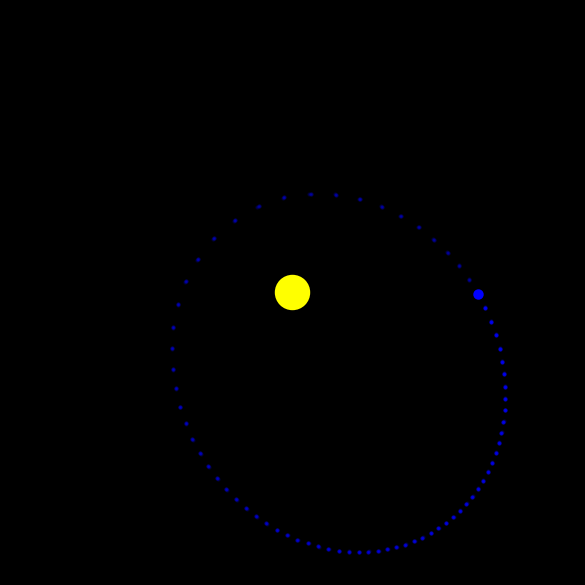

In [35]:
plot_orbits(data)

The Earth is now on an eccentric orbit around the sound. By the spacing of the snapshots, which are constant in time, you can even tell that the Earth is faster around the perihelion and slower around the aphelion.

**Adding Temperature**

To calculate the temperature Earth and Sun need additional fields for their temperatures and their radii. In additional to that, we give the Earth an additional field for the Earth-Sun distance.

In [36]:
R_Earth = c.R_earth.si.value
R_Sun   = c.R_sun.si.value

We initialize the Earth's temperature with zero and update it as soon as we have a function for it.

In [37]:
sim.Earth.addfield("d", AU, description="Earth-Sun distance [m]")
sim.Earth.addfield("R", R_Earth, description="Radius [m]")
sim.Earth.addfield("T", 0., description="Temperature [K]")

In [38]:
sim.Earth

Group
-----
    d            : Field (Earth-Sun distance [m])
    M            : Field (Mass [kg]), constant
    r            : Field (Position [m])
    R            : Field (Radius [m])
    T            : Field (Temperature [K])
    v            : Field (Velocity [m/s])
  -----

In [39]:
sim.Sun.addfield("R", R_Sun, description="Radius [m]", constant=True)
sim.Sun.addfield("T", 5778, description="Effective temperature [K]", constant=True)

In [40]:
sim.Sun

Group
-----
    M            : Field (Mass [kg]), constant
    r            : Field (Position [m])
    R            : Field (Radius [m]), constant
    T            : Field (Effective temperature [K]), constant
    v            : Field (Velocity [m/s])
  -----

## Updating fields

The energy the sun is emitting per time, i.e., it's luminosity $L$, is given by

$L_\odot = 4\pi R_\odot^2 \sigma_\mathrm{SB} T_\mathrm{eff}^4$.

The energy flux arriving at Earth, i.e., the Solar constant $S$ is then given by

$S = \frac{L}{4\pi d^2}$.

Only one hemisphere of the Earth is illuminated at any time, so the energy that the Earth is receiving per unit time, neglecting any albedo effects, is given by

$P_\mathrm{in} = \pi R_\oplus^2 S$.

We assume that the temperature on Earth is in euilibrium, i.e., there is no difference between day and night. The energy the Earth is emitting per unit time is then given by

$P_\mathrm{out} = 4\pi R_\oplus^2 \sigma_\mathrm{SB} T^4$.

In equilibrium both are equal $\left( P_\mathrm{in} = P_\mathrm{out} \right)$ and we can solve for $T$

$T = T_\mathrm{eff} \sqrt[4]{\frac{R_\odot^2}{4d^2}}$.

So the equilibrium temperature on Earth depends on the Sun's effective temperature $T_\mathrm{eff}$, the Sun's radius $R_\odot$, and the Earth-Sun distance $d$. We can now write a function that takes the frame object as argument and returns Earth's temperature.

In [41]:
sigma_sb = c.sigma_sb.si.value

In [42]:
def T(frame):
    return frame.Sun.T * (frame.Sun.R**2 / (4.*frame.Earth.d**2))**0.25

We can now assign this function to the updater of the temperature field

In [43]:
sim.Earth.T.updater = T

The function for calculating the Earth-Sun distance is pretty simple and can be simply assigned to the updater of the field.

In [44]:
def d(sim):
    return np.linalg.norm(sim.Earth.r - sim.Sun.r)

In [45]:
sim.Earth.d.updater = d

Right now the temperature is zero as we initialized it.

In [46]:
sim.Earth.T

0.0

We can now use our the updater of the temperature field to calculate it's initial value

In [47]:
sim.Earth.T.update()

In [48]:
sim.Earth.T

278.6190681198289

## Updating groups

But before we can rerun the simulation we have to tell `simframe` how to update groups. This is not done automatically, because for one, not all fields and groups need to be updated, and second, the order of update matters. In our case, we do not need to update the group of the Sun, because it's temperature is not changing, and we need to update the Earth-Sun distance before we update the Earth's temperature, because we need the distance for it.

The only update operation that is performed once per time step is the update of the frame object `Frame.update()`. From here we have to delegate tasks down the tree structure.

There are in principle two methods of updating groups. One is by writing a function and assigning it to the group's updater. Here we write a function that is calling Earth's updater and assign it to theupdater of the frame.

In [49]:
def update_Earth(frame):
    frame.Earth.update()

In [50]:
sim.updater = update_Earth

The second method is by assigning a list of group attributes to an updater. The updater is then calling the updaters of these attributes in exactly that order.

In [51]:
sim.Earth.updater = ["d", "T"]    # Earth-Sun distance first, then temperature

**Resetting to initial conditions**

We can now reset to the initial conditions we have saved earlier, reset the namespace writer, and run the simulation again.

In [52]:
sim.Earth.r = r_Earth_ini
sim.Earth.v = v_Earth_ini
sim.Sun.r   = r_Sun_ini
sim.Sun.v   = v_Sun_ini
sim.t       = 0.
sim.writer.reset()

In [53]:
sim.run()

**Reading and plotting**

In [54]:
data_T = sim.writer.read.all()

In [55]:
def plot_temperature(data):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(data.t/year, (data.Earth.T*u.K).to(u.Celsius, equivalencies=u.temperature()), c="C3", label="Temperature")
    ax.plot(-2., 0., label="Earth-Sun distance", c="C0")
    ax.set_xlabel("Time [years]")
    ax.set_ylabel("Temperature [°C]")
    ax.set_xlim(data.t[0]/year, data.t[-1]/year)
    ax.set_ylim(-100., 150.)
    axr = ax.twinx()
    axr.plot(data.t/year, data.Earth.d/AU, c="C0")
    axr.set_ylabel("Distance [AU]")
    axr.set_ylim(0., 2.0)
    ax.legend()
    fig.tight_layout()

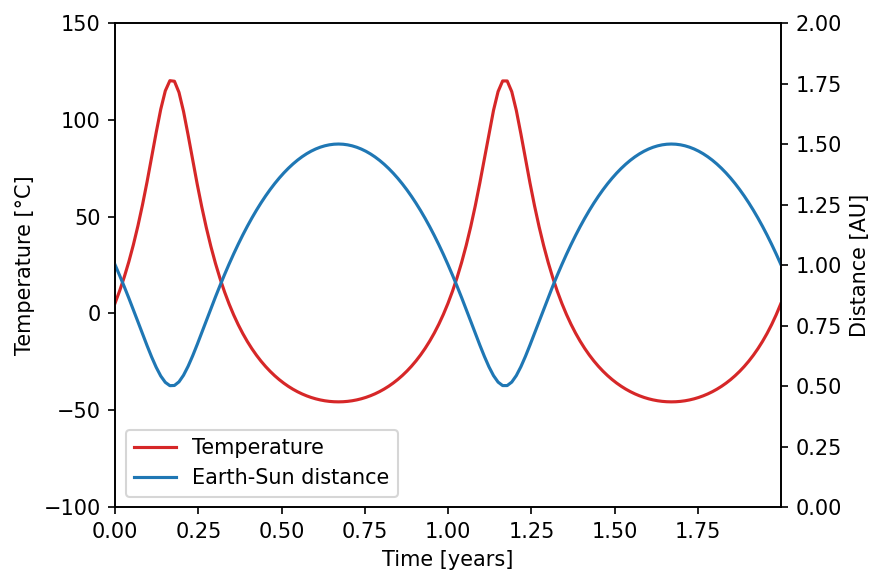

In [56]:
plot_temperature(data_T)

## The heartbeat concept

Every updater is actually performing three operations. The updater operation itself, a **"systole"**, that is executed before the update operation and a **"diastole"** that is executed after the update operation.

In this simple case we want to print Earth's temperature before and after it's calculation.

In [57]:
def T_sys(frame):
    msg = "{:6s}: T = {:5.1f} K".format("Before", sim.Earth.T)
    print(msg)

In [58]:
def T_dia(frame):
    msg = "{:6s}: T = {:5.1f} K".format("After", sim.Earth.T)
    print(msg)

We can assign these functions to systole and diastole of the temperature updater.

In [59]:
sim.Earth.T.updater.systole = T_sys
sim.Earth.T.updater.diastole = T_dia

In [60]:
sim.Earth.T = 0.

In [61]:
sim.Earth.T.update()

Before: T =   0.0 K
After : T = 278.0 K


Note: The updater of an integration variable is not directly setting its new value. Only the integrator is setting the new value of the integration variable after all integration instructions have been executed successfully. This has the consequence, that the diastole of an integration variable _DOES NOT_ have access to the updated value.